In [30]:
from nltk.corpus import movie_reviews
import random
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from tinycp.classifier import BinaryClassConditionalConformalClassifier
from sklearn.utils.validation import check_is_fitted
random.seed(42)
from tinycp.plot import efficiency_curve, confusion_matrix
nltk.download('movie_reviews')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from typing import Any, Dict, Optional
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/heylucasleao/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [31]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)
texts = [" ".join(words) for words, label in documents]
labels = [label for words, label in documents]

In [32]:
df = pd.DataFrame({'Text': texts, 'Sentiment': labels})
df = pd.concat([df[df['Sentiment'] == 'pos'], df[df['Sentiment'] == 'neg'].sample(frac=0.15, random_state=42)])
df["Sentiment"] = df["Sentiment"].replace({"pos": 1, "neg": 0})
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment'])

/tmp/ipykernel_341738/2636742680.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Sentiment"] = df["Sentiment"].replace({"pos": 1, "neg": 0})


In [ ]:
class SentimentAnalyzer(BaseEstimator, ClassifierMixin):
    """A sentiment analysis classifier combining TF-IDF text vectorization with a machine learning model.

    This class wraps a scikit-learn compatible classifier with TF-IDF vectorization for text classification tasks.
    It handles the entire pipeline from text preprocessing to prediction, including probability calibration.

    """

    def __init__(
        self,
        learner: RandomForestClassifier = RandomForestClassifier(
            random_state=42, 
            oob_score=True, 
            n_jobs=-1, 
            class_weight="balanced", 
            max_depth=int(np.ceil(np.log2(len(X_train)) - 1)),
            min_samples_leaf=5
        ),
        **tfidf_kwargs,
    ) -> None:
        """Initialize the SentimentAnalyzer with optional configurations.

        Args:
            learner_: Base estimator for classification. Defaults to balanced RandomForestClassifier.
            **tfidf_kwargs: Additional keyword arguments for TfidfVectorizer.
        """
        self.tfidf_ = TfidfVectorizer(**tfidf_kwargs)
        self.learner = learner
        self.is_fitted_ = False
    
    def __getattr__(self, name):
        return getattr(self.learner, name)
    
    def _check_is_fitted(self) -> None:
        """Check if both the TF-IDF vectorizer and learner are fitted."""
        if not self.is_fitted_:
            raise ValueError(
                "This %(name)s instance is not fitted yet. Call 'fit' with "
                "appropriate arguments before using this estimator."
                % {"name": type(self).__name__}
            )
        check_is_fitted(self.tfidf_)
        check_is_fitted(self.learner)

    def fit(self, X: np.ndarray, y: np.ndarray) -> "SentimentAnalyzer":
        """Fit the model to training data.

        Args:
            X: Training text data (iterable of strings).
            y: Target labels.

        Returns:
            self: Returns the instance itself.
        """
        self.learner.fit(self.tfidf_.fit_transform(X), y)
        self.is_fitted_ = True
        return self

    def transform(self, X: np.ndarray) -> csr_matrix:
        """Transform text data using the fitted TF-IDF vectorizer.
        """
        self._check_is_fitted()
        return self.tfidf_.transform(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray[np.float64]:
        """Predict class probabilities for the input data.
        """
        return self.learner.predict_proba(self.transform(X))

    def predict_logit(
        self, X: np.ndarray
    ) -> np.ndarray[np.float64]:
        """Predict log-odds (logit transform of probabilities) for the input data."""
        epsilon = 1e-10
        y_prob = np.clip(self.predict_proba(X), epsilon, 1 - epsilon)
        return np.log(y_prob / (1 - y_prob))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for the input data."""
        return self.learner.predict(self.transform(X))

In [66]:
model = SentimentAnalyzer()
model.fit(X_train, y_train)

SentimentAnalyzer()

In [67]:
clf = BinaryClassConditionalConformalClassifier(model)
clf.fit(y=y_train.values, oob=True)

In [68]:
clf.calibrate(
    X_train, 
    y_train, 
    func="bm",
    max_alpha=0.3)

0.29

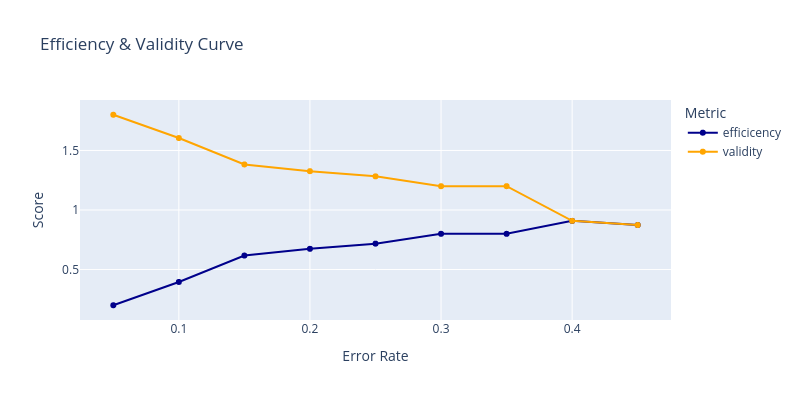

In [69]:
efficiency_curve(clf, X_test, fig_type="png")

In [70]:
clf.evaluate(X_test, y_test)

{'total': 230,
 'alpha': 0.29,
 'coverage_rate': 0.878,
 'one_c': 0.8,
 'avg_c': 1.2,
 'empty': 0.0,
 'error': 0.122,
 'log_loss': 0.317,
 'ece': 0.034,
 'bm': 0.462,
 'mcc': 0.323,
 'f1': 0.803,
 'fpr': 0.233}

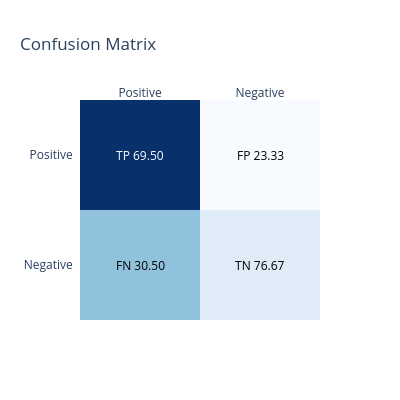

In [71]:
confusion_matrix(clf, X_test, y_test, fig_type="png")